# Analysis of Accelerator-VC Bipartite Networks

Analysis of the USA accelerator-VC network using ecological metrics inspired by Theo's work on complex networks in entrepreneurial ecosystems.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# import sys

# sys.path.append('../../') 

# Import custom modules
from libs.data_cleaning import *
from libs.data_extraction import *
from libs.network_analysis import *

plt.style.use('default')
sns.set_palette('husl')

## Data Loading and Preparation

In [48]:
country = "france"
data_dir = f'../../data/{country}'

cleaned_data = load_clean_data(data_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")

After cleaning:
Companies: 2,361
Investors: 4,564
Investments: 10,163
Funding rounds: 14,375


## VC-Bipartite Network Construction

Early-stage:
- Pre-seed
- Seed
- Series A

Late-stage:
- Series B em diante (B, C, D...)

In [49]:
vc_investments = extract_vc_investments(cleaned_data['investments'])

vc_investments['investor_uuid'] = vc_investments[['investor_uuid', 'investment_type']].agg('-'.join, axis=1)
vc_investments['investor_name'] = vc_investments[['investor_name', 'investment_type']].agg('-'.join, axis=1)


early_stages = set(['angel', 'pre_seed', 'seed', 'series_a'])
vc_early_investments = vc_investments[vc_investments['investment_type'].isin(early_stages)]

late_stages = set(['series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i', 'series_unknown'])
vc_late_investments = vc_investments[vc_investments['investment_type'].isin(late_stages)]

print("\nSample of VC investments:")
display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
print(vc_investments[display_cols].head())

print("\VC-VC pairs:")
vc_vc_investments_pairs = create_investment_pairs(vc_early_investments, vc_late_investments, 'left_vc', 'right_vc')
vc_vc_investments_pairs['announced_year'] = vc_vc_investments_pairs[['announced_year_left_vc', 'announced_year_right_vc']].max(axis=1)
vc_vc_investments_pairs['total_funding_usd'] = (vc_vc_investments_pairs['total_funding_usd_left_vc'])
print(vc_vc_investments_pairs[['org_uuid', 'investor_name_left_vc', 'total_funding_usd_left_vc','total_funding_usd_right_vc']].head())

Found 5826 VC investments
Unique companies with VC funding: 1849

Sample of VC investments:
           company_name               investor_name  \
0                TVtrip  Balderton Capital-series_a   
1                TVtrip            Partech-series_a   
2                Twenga               3i Group-seed   
4                 MyFab              Alven-series_a   
6  Inspirational Stores      Atlas Venture-series_b   

                        investor_types  total_funding_usd  
0                      venture capital         13770000.0  
1                      venture capital         13770000.0  
2  private equity firm,venture capital         14790959.0  
4                      venture capital         10176279.0  
6                      venture capital         11470000.0  
\VC-VC pairs:
Created 5085 investment pairs
Covering 383 unique investors
                               org_uuid       investor_name_left_vc  \
0  a0f5e737-d973-703c-7f66-0fc31d0e4b5b  Balderton Capital-series_a   
1

## Static Ecological Network Analysis

Analysis using ecological metrics inspired by Carniel's framework.

In [ ]:
""" vc_vc_edges = extract_bipartite_edges_from_pairs(
    vc_vc_investments_pairs, 
    'investor_name_left_vc', 
    'investor_name_right_vc',
    'total_funding_usd'
) """

# Bbipartite analysis with ecological metrics
network_analysis = analyze_bipartite_structure_robust(
    vc_vc_investments_pairs[['investor_name_left_vc', 'investor_name_right_vc', 'total_funding_usd']],
    'investor_name_left_vc',
    'investor_name_right_vc',
    'total_funding_usd',
    'VCs left',
    'VCs right',
    handle_overlap='suffix'
)

# Extract key metrics
basic_metrics = network_analysis['basic_metrics']
ecological_summary = network_analysis['ecological_summary']

print("=== Network Structure ===")
print(f"Nodes: {basic_metrics['num_nodes']} ({basic_metrics['set_0_size']} accelerators + {basic_metrics['set_1_size']} VCs)")
print(f"Edges: {basic_metrics['num_edges']}")
print(f"Density: {basic_metrics['density']:.3f}")
print(f"Components: {basic_metrics['num_components']}")

print("\n=== Ecological Metrics ===")
print(f"Connectance: {ecological_summary['connectance']:.3f}") # Or density
print(f"Nestedness (NODF): {ecological_summary['nestedness_nodf']:.1f}")
print(f"Modularity: {ecological_summary['modularity']:.3f}")

=== Network Structure ===
Nodes: 1467 (477 accelerators + 990 VCs)
Edges: 4739
Density: 0.010
Components: 22

=== Ecological Metrics ===
Connectance: 0.010
Nestedness (NODF): 2.9
Modularity: 0.352


#### Comments

...

## Time Series Ecological Network Analysis

In [51]:
# Extract year from funding rounds for time series analysis
# Merge investment data with funding rounds to get temporal information
vc_vc_inv_pairs_ts = vc_vc_investments_pairs.copy()

# Convert to datetime and extract year
# vc_vc_inv_pairs_ts['announced_year'] = pd.to_datetime(vc_vc_inv_pairs_ts['announced_year'])
vc_vc_inv_pairs_ts['year'] = vc_vc_inv_pairs_ts['announced_year']

# Get the range of years
min_year = 2005
max_year = 2023

# Filter out rows with missing dates
vc_vc_inv_pairs_ts = vc_vc_inv_pairs_ts.dropna(subset=['year'])
vc_vc_inv_pairs_ts = vc_vc_inv_pairs_ts[(vc_vc_inv_pairs_ts['year'] >= min_year) & (vc_vc_inv_pairs_ts['year'] <= max_year)]


print(f"Time series analysis from {min_year} to {max_year}")
print(f"Total investments with dates: {len(vc_vc_inv_pairs_ts):,}")

# Show distribution by year
year_counts = vc_vc_inv_pairs_ts['year'].value_counts().sort_index()
print(f"\nInvestments per year:")
print(year_counts)

Time series analysis from 2005 to 2023
Total investments with dates: 4,667

Investments per year:
year
2006     16
2007     12
2008     17
2009     39
2010     29
2011      8
2012     42
2013     60
2014    129
2015    373
2016    115
2017    232
2018    380
2019    608
2020    361
2021    852
2022    900
2023    494
Name: count, dtype: int64


### Snapshot-based analysis

In [ ]:
# Initialize storage for time series metrics
time_series_metrics = []

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print("Computing ecological metrics for each year...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year, max_year + 1):
    cur_year_vc_vc_inv_pairs = vc_vc_inv_pairs_ts[vc_vc_inv_pairs_ts['year'] == year]

    if len(cur_year_vc_vc_inv_pairs) < min_edges_threshold:
        print(f"Year {year}: Skipping (only {len(cur_year_vc_vc_inv_pairs)} investments)")
        continue
    
    try:
        # Extract bipartite edges for this year
        """ year_edges = extract_bipartite_edges_from_pairs(
            cur_year_vc_vc_inv_pairs,
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd'
        ) """

        # Analyze bipartite structure for this year
        year_analysis = analyze_bipartite_structure_robust(
            cur_year_vc_vc_inv_pairs[['investor_name_left_vc', 'investor_name_right_vc', 'total_funding_usd']],
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd',
            'VCs left',
            'VCs right',
            handle_overlap='suffix'
        )
        
        # Extract metrics
        basic_metrics = year_analysis['basic_metrics']
        ecological_summary = year_analysis['ecological_summary']
        
        # Store metrics for this year
        year_metrics = {
            'year': year,
            'num_nodes': basic_metrics['num_nodes'],
            'num_vcs_left': basic_metrics['set_0_size'],
            'num_vcs_right': basic_metrics['set_1_size'],
            'num_edges': basic_metrics['num_edges'],
            'density': basic_metrics['density'],
            'connectance': ecological_summary['connectance'],
            'nestedness_nodf': ecological_summary['nestedness_nodf'],
            'modularity': ecological_summary['modularity'],
            'cross_assortativity': ecological_summary['cross_assortativity'],
            'num_components': basic_metrics['num_components']
        }
        
        time_series_metrics.append(year_metrics)
        
        print(f"Year {year}: {basic_metrics['num_nodes']} nodes, {basic_metrics['num_edges']} edges, "
              f"Connectance: {ecological_summary['connectance']:.3f}, "
              f"Nestedness: {ecological_summary['nestedness_nodf']:.1f}, "
              f"Modularity: {ecological_summary['modularity']:.3f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(time_series_metrics)} years")

Computing ecological metrics for each year...
Year 2005: Skipping (only 0 investments)
Year 2006: 14 nodes, 15 edges, Connectance: 0.375, Nestedness: 40.0, Modularity: 0.318
Year 2007: 15 nodes, 12 edges, Connectance: 0.222, Nestedness: 0.0, Modularity: 0.420
Year 2008: 20 nodes, 17 edges, Connectance: 0.187, Nestedness: 8.3, Modularity: 0.430
Year 2009: 36 nodes, 39 edges, Connectance: 0.122, Nestedness: 3.8, Modularity: 0.457
Year 2010: 30 nodes, 28 edges, Connectance: 0.130, Nestedness: 8.9, Modularity: 0.443
Year 2011: Skipping (only 8 investments)
Year 2012: 32 nodes, 42 edges, Connectance: 0.170, Nestedness: 1.6, Modularity: 0.444
Year 2013: 37 nodes, 60 edges, Connectance: 0.182, Nestedness: 0.0, Modularity: 0.382
Year 2014: 86 nodes, 127 edges, Connectance: 0.072, Nestedness: 1.9, Modularity: 0.450
Year 2015: 146 nodes, 370 edges, Connectance: 0.072, Nestedness: 1.3, Modularity: 0.414
Year 2016: 96 nodes, 115 edges, Connectance: 0.050, Nestedness: 1.8, Modularity: 0.461
Year 20

In [53]:
# Convert to DataFrame for easier analysis and plotting
ts_df = pd.DataFrame(time_series_metrics)

if len(ts_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_df.describe().round(3))
    
    print(f"\nData available for years: {ts_df['year'].min()} to {ts_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_vcs_left  num_vcs_right  num_edges  density  \
count    17.000     17.000        17.000         17.000     17.000   17.000   
mean   2014.706    145.176        63.294         81.882    270.647    0.105   
std       5.429    132.043        57.041         75.834    290.357    0.097   
min    2006.000     14.000         4.000          9.000     12.000    0.021   
25%    2010.000     32.000        13.000         19.000     39.000    0.029   
50%    2015.000     96.000        52.000         52.000    127.000    0.072   
75%    2019.000    235.000       103.000        132.000    372.000    0.170   
max    2023.000    411.000       184.000        227.000    893.000    0.375   

       connectance  nestedness_nodf  modularity  cross_assortativity  \
count       17.000           17.000      17.000               17.000   
mean         0.105            5.070       0.430                0.184   
std          0.097            9.313       0

Evolution of ecological metrics over time in the accelerator-VC ecosystem.

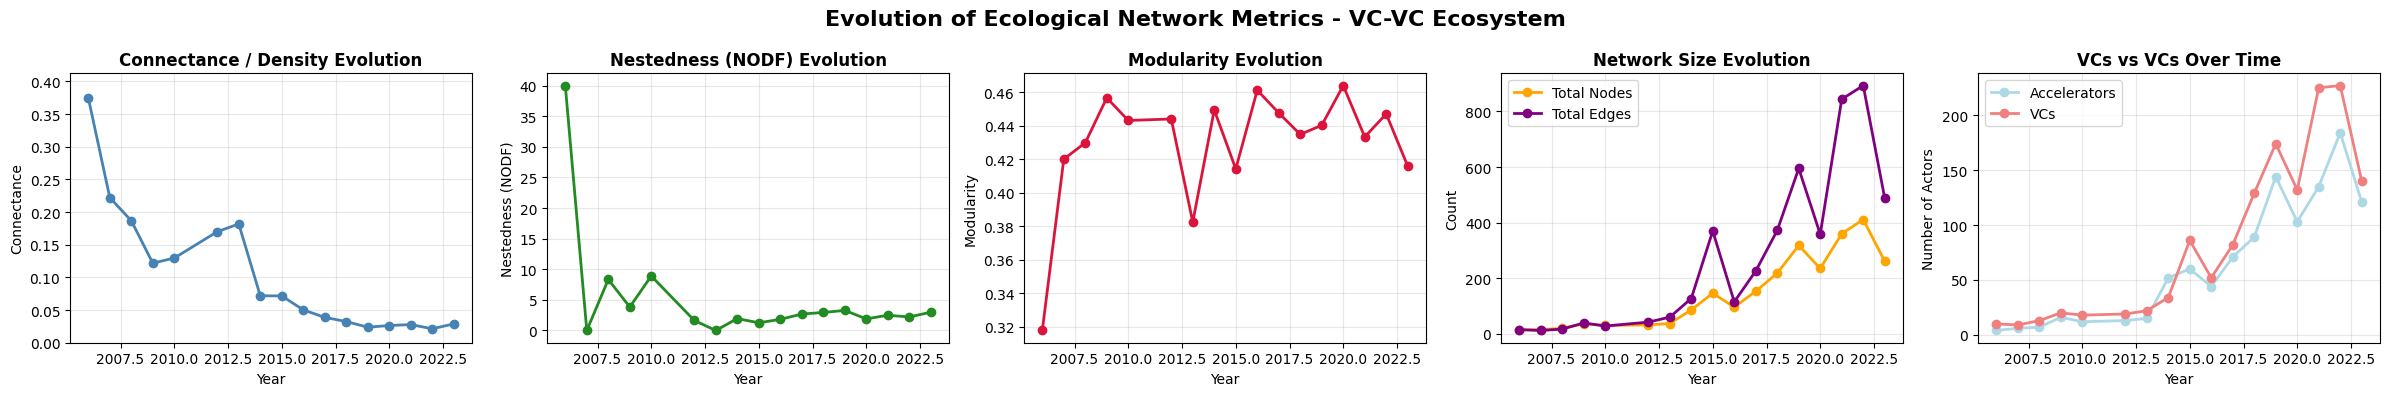

In [54]:
if len(ts_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(1, 5, figsize=(24, 4))
    fig.suptitle('Evolution of Ecological Network Metrics - VC-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0].plot(ts_df['year'], ts_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Connectance')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(ts_df['connectance']) * 1.1)
    
    # Nestedness evolution
    axes[1].plot(ts_df['year'], ts_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Nestedness (NODF)')
    axes[1].grid(True, alpha=0.3)
    
    # Modularity evolution
    axes[2].plot(ts_df['year'], ts_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[2].set_title('Modularity Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Modularity')
    axes[2].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[3].plot(ts_df['year'], ts_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[3].plot(ts_df['year'], ts_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[3].set_title('Network Size Evolution', fontweight='bold')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('Count')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    axes[4].plot(ts_df['year'], ts_df['num_vcs_left'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='Accelerators')
    axes[4].plot(ts_df['year'], ts_df['num_vcs_right'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs')
    axes[4].set_title('VCs vs VCs Over Time', fontweight='bold')
    axes[4].set_xlabel('Year')
    axes[4].set_ylabel('Number of Actors')
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: -0.0216 per year (total: -0.3462)
nestedness_nodf: -2.3137 per year (total: -37.0194)
modularity: +0.0061 per year (total: +0.0982)
num_nodes: +15.4375 per year (total: +247.0000)
num_edges: +29.5625 per year (total: +473.0000)

Correlations between metrics and time:
connectance: r=-0.861 (decreasing trend)
nestedness_nodf: r=-0.463 (decreasing trend)
modularity: r=0.398 (increasing trend)


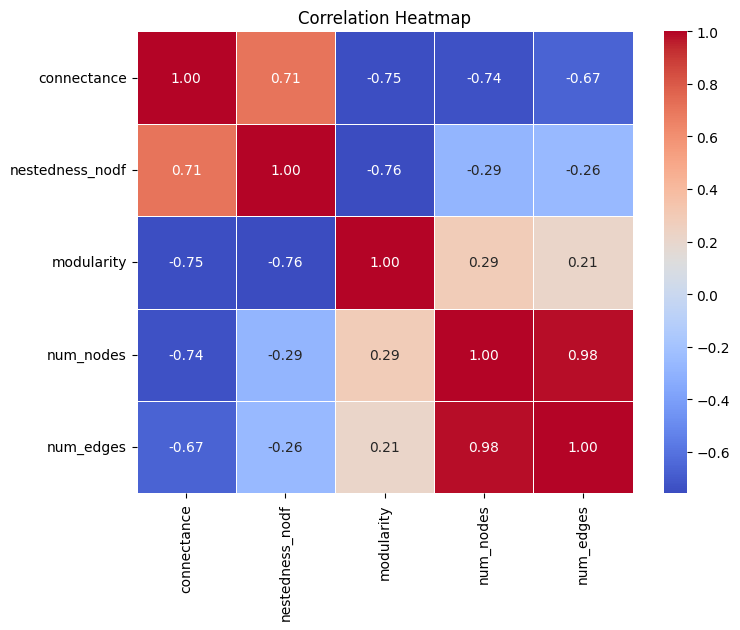

In [55]:
if len(ts_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_df_sorted = ts_df.sort_values('year')
    
    metrics_to_analyze = ['connectance', 'nestedness_nodf', 'modularity', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in metrics_to_analyze:
        if metric in ts_df_sorted.columns:
            # Calculate differences
            diffs = ts_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_df_sorted[metric].iloc[-1] - ts_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    # Correlation analysis
    print("\nCorrelations between metrics and time:")
    for metric in ['connectance', 'nestedness_nodf', 'modularity']:
        if metric in ts_df.columns:
            correlation = ts_df['year'].corr(ts_df[metric])
            trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
            print(f"{metric}: r={correlation:.3f} ({trend_direction} trend)")
            
    matrix = ts_df_sorted[metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")

### Cumulative network analysis (5 years window)

In [ ]:
# Initialize storage for time series metrics
ts_cumulative_metrics = []
cumulative_window = 5

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print(f"Computing ecological metrics for each year ({cumulative_window} years window)...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year + cumulative_window, max_year + 1):
    cur_window_vc_vc_inv_pairs = vc_vc_inv_pairs_ts[(vc_vc_inv_pairs_ts['year'] <= year) & (vc_vc_inv_pairs_ts['year'] >= year - cumulative_window)]
    
    try:
        # Extract bipartite edges for this year
        """ window_edges = extract_bipartite_edges_from_pairs(
            cur_window_vc_vc_inv_pairs,
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd'
        ) """
        
        # Analyze bipartite structure for this year
        window_analysis = analyze_bipartite_structure_robust(
            cur_window_vc_vc_inv_pairs[['investor_name_left_vc', 'investor_name_right_vc', 'total_funding_usd']],
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd',
            'VCs left',
            'VCs right',
            handle_overlap='suffix'
        )
        
        # Extract metrics
        cumulative_basic_metrics = window_analysis['basic_metrics']
        cumulative_eco_summary = window_analysis['ecological_summary']
        
        # Store metrics for this year
        cumulative_year_metrics = {
            'year': year,
            'num_nodes': cumulative_basic_metrics['num_nodes'],
            'num_vcs_left': cumulative_basic_metrics['set_0_size'],
            'num_vcs_right': cumulative_basic_metrics['set_1_size'],
            'num_edges': cumulative_basic_metrics['num_edges'],
            'density': cumulative_basic_metrics['density'],
            'connectance': cumulative_eco_summary['connectance'],
            'nestedness_nodf': cumulative_eco_summary['nestedness_nodf'],
            'modularity': cumulative_eco_summary['modularity'],
            'cross_assortativity': cumulative_eco_summary['cross_assortativity'],
            'num_components': cumulative_basic_metrics['num_components']
        }
        
        ts_cumulative_metrics.append(cumulative_year_metrics)
        
        print(f"Year {year}: {cumulative_basic_metrics['num_nodes']} nodes, {cumulative_basic_metrics['num_edges']} edges, "
              f"Connectance: {cumulative_eco_summary['connectance']:.3f}, "
              f"Nestedness: {cumulative_eco_summary['nestedness_nodf']:.1f}, "
              f"Modularity: {cumulative_eco_summary['modularity']:.3f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(ts_cumulative_metrics)} years")

Computing ecological metrics for each year (5 years window)...
Year 2010: 96 nodes, 107 edges, Connectance: 0.051, Nestedness: 7.4, Modularity: 0.452
Year 2011: 102 nodes, 114 edges, Connectance: 0.049, Nestedness: 7.4, Modularity: 0.450
Year 2012: 110 nodes, 140 edges, Connectance: 0.053, Nestedness: 6.5, Modularity: 0.431
Year 2013: 131 nodes, 190 edges, Connectance: 0.050, Nestedness: 4.7, Modularity: 0.452
Year 2014: 175 nodes, 297 edges, Connectance: 0.040, Nestedness: 3.5, Modularity: 0.449
Year 2015: 262 nodes, 628 edges, Connectance: 0.039, Nestedness: 2.4, Modularity: 0.433
Year 2016: 304 nodes, 708 edges, Connectance: 0.032, Nestedness: 2.1, Modularity: 0.439
Year 2017: 390 nodes, 912 edges, Connectance: 0.025, Nestedness: 2.4, Modularity: 0.434
Year 2018: 524 nodes, 1238 edges, Connectance: 0.019, Nestedness: 2.5, Modularity: 0.434
Year 2019: 688 nodes, 1738 edges, Connectance: 0.016, Nestedness: 2.8, Modularity: 0.396
Year 2020: 777 nodes, 1956 edges, Connectance: 0.014, Ne

In [61]:
# Convert to DataFrame for easier analysis and plotting
ts_cumulative_df = pd.DataFrame(ts_cumulative_metrics)

if len(ts_cumulative_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_cumulative_df.describe().round(3))
    
    print(f"\nData available for years: {ts_cumulative_df['year'].min()} to {ts_cumulative_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_cumulative_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_vcs_left  num_vcs_right  num_edges  density  \
count    14.000     14.000        14.000         14.000     14.000   14.000   
mean   2016.500    474.071       168.214        305.857   1215.000    0.031   
std       4.183    371.114       125.214        246.751   1145.234    0.016   
min    2010.000     96.000        33.000         63.000    107.000    0.012   
25%    2013.250    142.000        50.750         91.250    216.750    0.014   
50%    2016.500    347.000       134.000        213.000    810.000    0.029   
75%    2019.750    754.750       279.750        475.000   1901.500    0.047   
max    2023.000   1137.000       381.000        756.000   3414.000    0.053   

       connectance  nestedness_nodf  modularity  cross_assortativity  \
count       14.000           14.000      14.000               14.000   
mean         0.031            3.826       0.419                0.058   
std          0.016            1.898       0

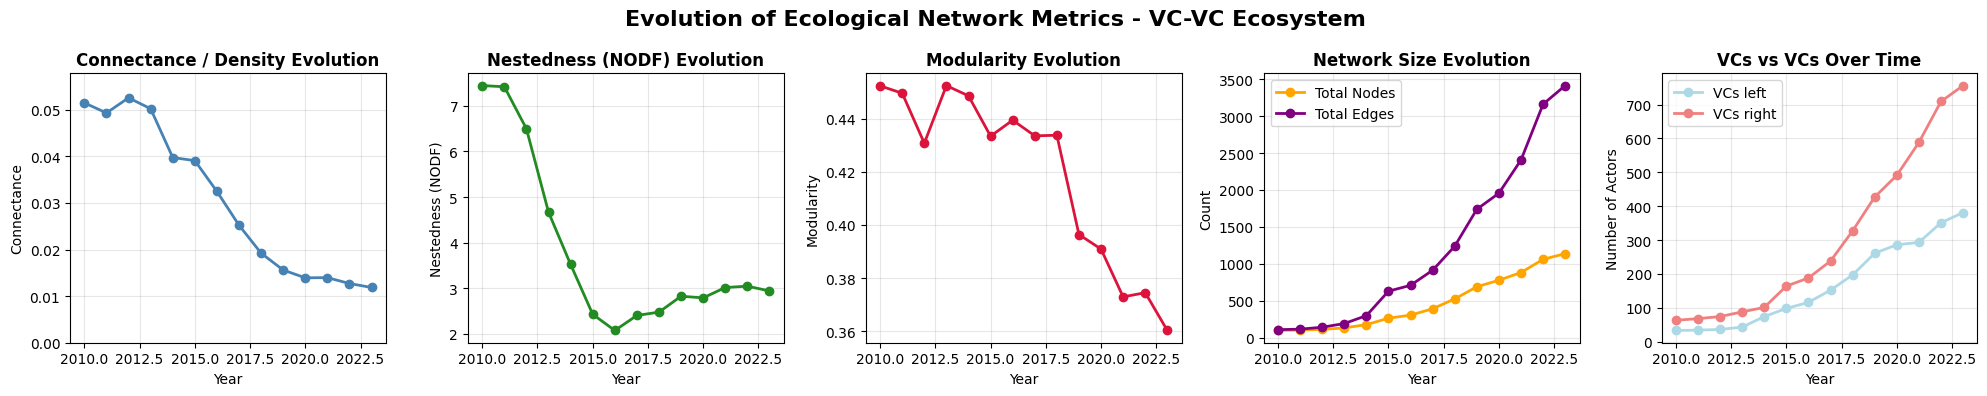

In [62]:
if len(ts_cumulative_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle('Evolution of Ecological Network Metrics - VC-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0].plot(ts_cumulative_df['year'], ts_cumulative_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Connectance')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(ts_cumulative_df['connectance']) * 1.1)
    
    # Nestedness evolution
    axes[1].plot(ts_cumulative_df['year'], ts_cumulative_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Nestedness (NODF)')
    axes[1].grid(True, alpha=0.3)
    
    # Modularity evolution
    axes[2].plot(ts_cumulative_df['year'], ts_cumulative_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[2].set_title('Modularity Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Modularity')
    axes[2].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[3].plot(ts_cumulative_df['year'], ts_cumulative_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[3].plot(ts_cumulative_df['year'], ts_cumulative_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[3].set_title('Network Size Evolution', fontweight='bold')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('Count')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    axes[4].plot(ts_cumulative_df['year'], ts_cumulative_df['num_vcs_left'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='VCs left')
    axes[4].plot(ts_cumulative_df['year'], ts_cumulative_df['num_vcs_right'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs right')
    axes[4].set_title('VCs vs VCs Over Time', fontweight='bold')
    axes[4].set_xlabel('Year')
    axes[4].set_ylabel('Number of Actors')
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: -0.0030 per year (total: -0.0396)
nestedness_nodf: -0.3461 per year (total: -4.4989)
modularity: -0.0071 per year (total: -0.0921)
num_nodes: +80.0769 per year (total: +1041.0000)
num_edges: +254.3846 per year (total: +3307.0000)

Correlations between metrics and time:
connectance: r=-0.967 (decreasing trend)
nestedness_nodf: r=-0.746 (decreasing trend)
modularity: r=-0.905 (decreasing trend)


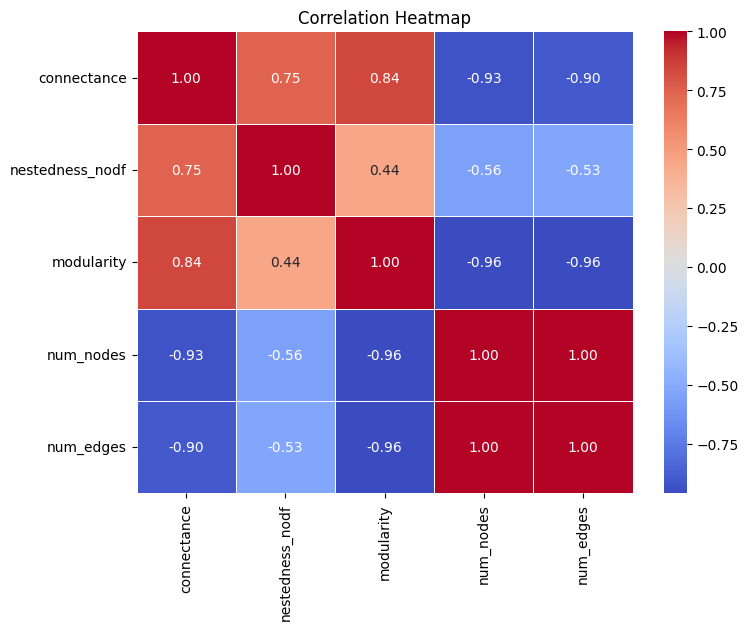

In [63]:
if len(ts_cumulative_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_cumulative_df_sorted = ts_cumulative_df.sort_values('year')
    
    cumulative_metrics_to_analyze = ['connectance', 'nestedness_nodf', 'modularity', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in cumulative_metrics_to_analyze:
        if metric in ts_cumulative_df_sorted.columns:
            # Calculate differences
            diffs = ts_cumulative_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_cumulative_df_sorted[metric].iloc[-1] - ts_cumulative_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    # Correlation analysis
    print("\nCorrelations between metrics and time:")
    for metric in ['connectance', 'nestedness_nodf', 'modularity']:
        if metric in ts_cumulative_df.columns:
            correlation = ts_cumulative_df['year'].corr(ts_cumulative_df[metric])
            trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
            print(f"{metric}: r={correlation:.3f} ({trend_direction} trend)")
            
    cum_matrix = ts_cumulative_df_sorted[cumulative_metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(cum_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")